# Plot GEBCO bathymetry and mask for the All European Seas domain

In [7]:
using DIVAnd
using ColorSchemes
using NCDatasets
using GeoDatasets
using CairoMakie, GeoMakie
using GeometryOps, GeoInterface
using JupyterFormatter
enable_autoformat()
include("./config.jl")

plot_field_var_fast (generic function with 3 methods)

In [8]:
using Pkg
Pkg.update()

    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/gher-uliege/DINCAE_utils.jl`
    Updating git-repo `https://github.com/gher-uliege/PhysOcean.jl.git`
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
Precompiling project...
    565.4 ms  ✓ Qt6ShaderTools_jll
   1823.5 ms  ✓ WebP
   1682.3 ms  ✓ Qt6Declarative_jll
    623.5 ms  ✓ Qt6Wayland_jll
  4 dependencies successfully precompiled in 4 seconds. 677 already precompiled.


## Load bathymetry 

In [9]:
topodir = "/home/ctroupin/data/GEBCO/"
topofile = joinpath(topodir, "gebco_30sec_16.nc")
bx, by, b = DIVAnd.extract_bath(topofile, true, lonr, latr)

# Mask land values
b[b.<0.0] .= NaN;

lon_landsea, lat_landsea, landsea = GeoDatasets.landseamask(; resolution = 'i', grid = 5)
landsea[landsea.==2] .= 1;

### Create and edit mask

In [10]:
xi, yi, mask = load_mask(topofile, true, lonr, latr, 0.0);
coordinatelist = read_polygon_json("./mask.json");
edit_mask!(xi, yi, mask, coordinatelist)

## Make the plot

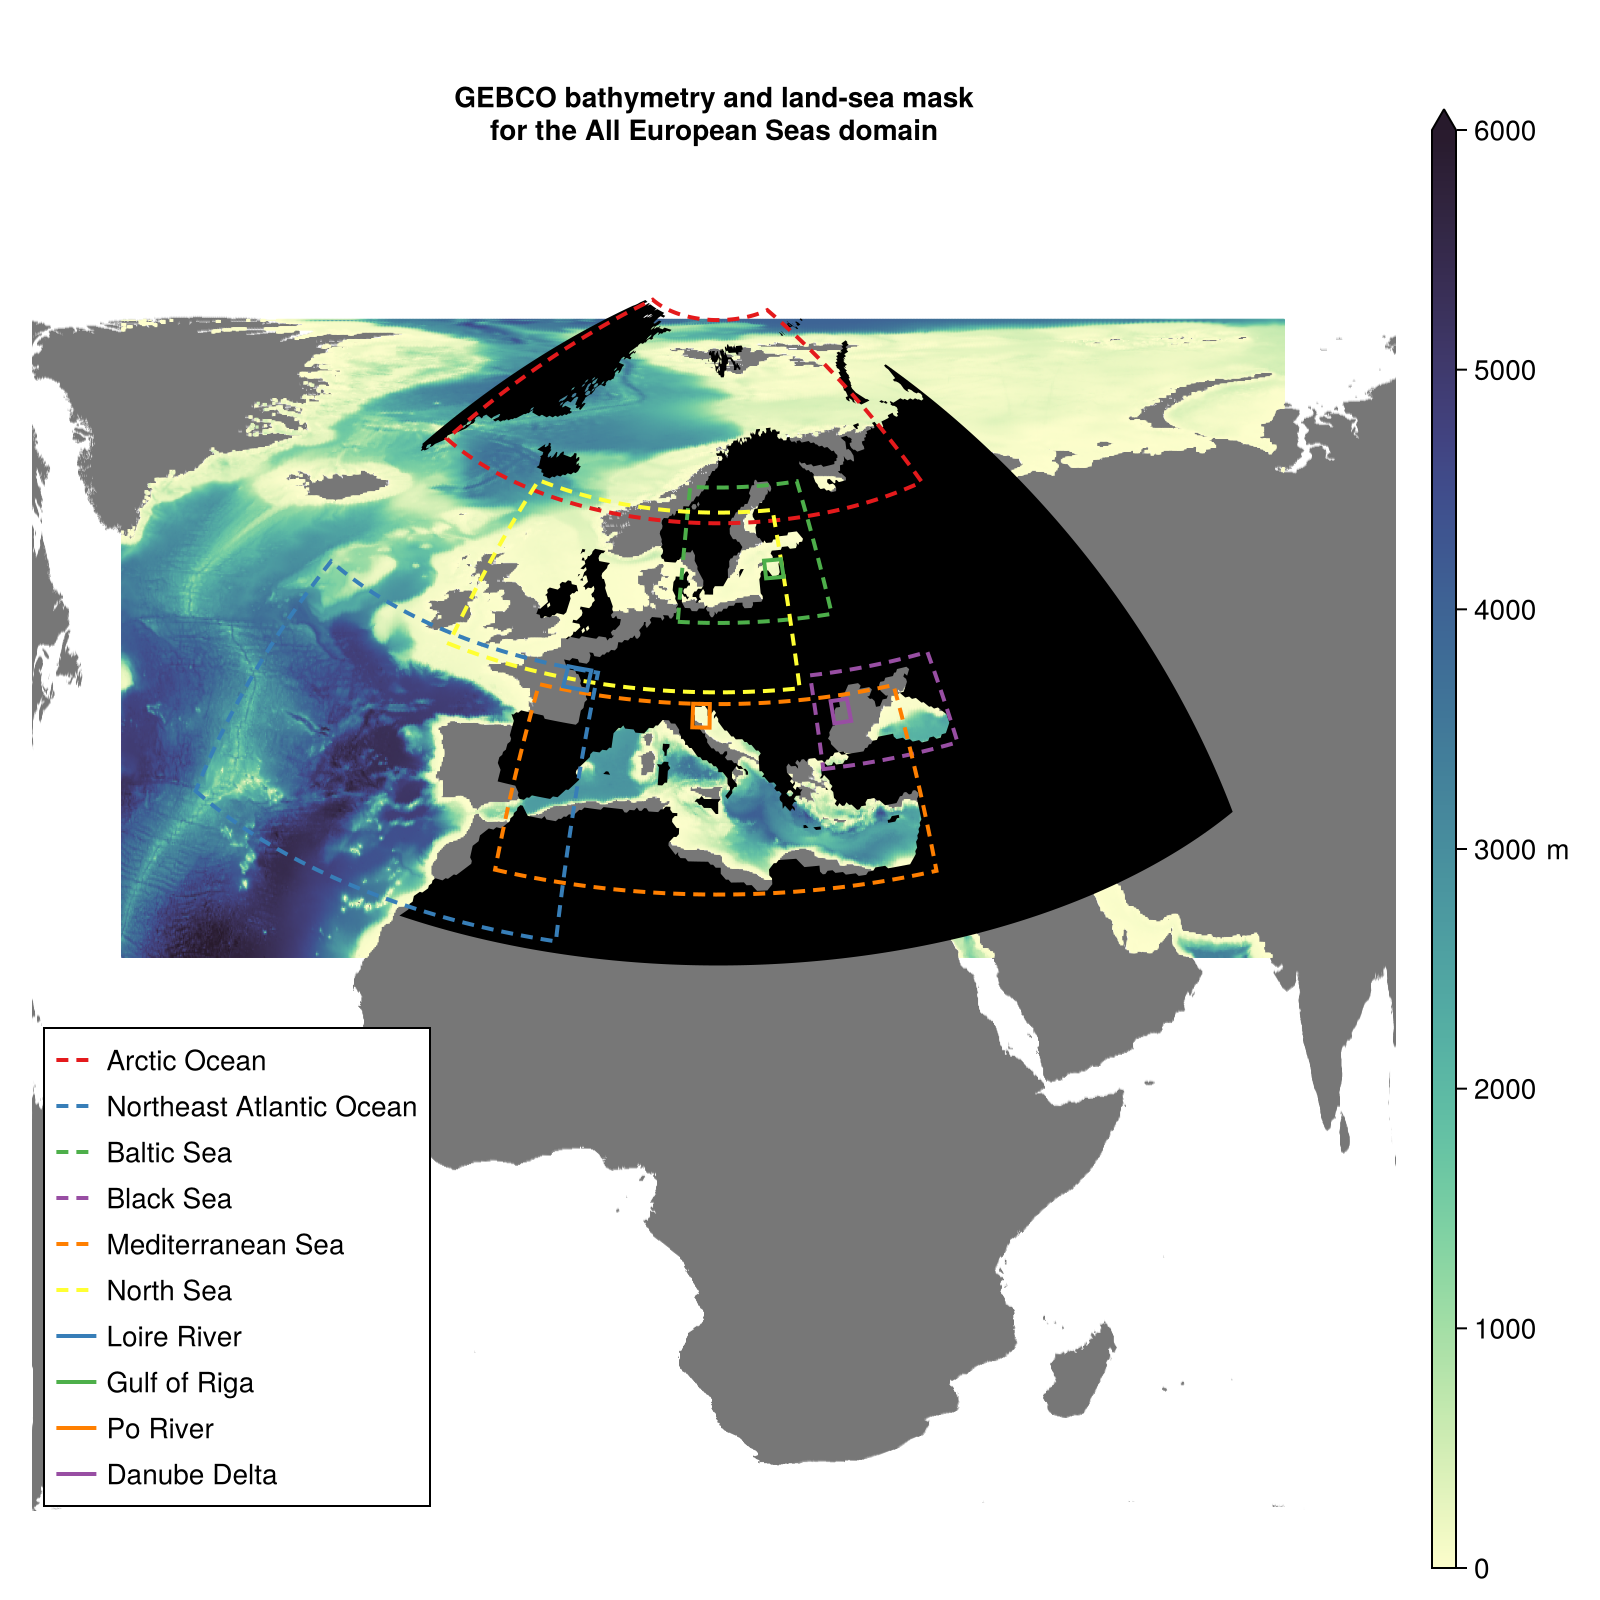

CairoMakie.Screen{PDF}


In [11]:
cmap = cgrad(:deep)

fig = Figure(size = (800, 800))
ga = GeoAxis(
    fig[1, 1],
    title = "GEBCO bathymetry and land-sea mask\nfor the All European Seas domain",
    dest = "+proj=ortho +lon_0=15 +lat_0=35",
)

surface!(
    ga,
    lon_landsea,
    lat_landsea,
    landsea,
    colormap = Reverse(:greys),
    colorrange = [0, 2],
    shading = NoShading,
)
hm = surface!(
    ga,
    bx,
    by,
    b,
    colormap = cmap,
    colorrange = (0, 6000.0),
    highclip = cmap.colors[end],
    shading = NoShading,
)
Colorbar(fig[1, 2], hm, label = "m", labelrotation = 0)

masklayer = contourf!(ga, xi, yi, mask, levels = [0.0, 0.0001], colormap = Reverse(:binary))

# Add regional domains
for (regionnames, regioncoords) in domains
    draw_domain(ga, regioncoords, domaincolors[regionnames], regionnames, (:dash, :dense))
end

# Add coastal domains
for (regionnames, regioncoords) in domainrivers
    draw_domain(ga, regioncoords, domainriverscolors[regionnames], regionnames)
end

axislegend(ga, position = :lb, framevisible = true)

xlims!(ga, -180, 180.0)
ylims!(ga, -90.0, 90.0)
hidedecorations!(ga)
# save(joinpath(figdir, "gebco_bathy_mask_domains3.png"), fig)
display(fig)